<a href="https://colab.research.google.com/github/CthulhuCoder01/rnn-model-to-check-country-by-name/blob/main/Name_Country_Model_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip

--2023-06-02 09:26:36--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.35.166.78, 13.35.166.68, 13.35.166.45, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.35.166.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  2.02MB/s    in 1.4s    

2023-06-02 09:26:39 (2.02 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [2]:
!unzip *.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [3]:
import os
import numpy as np
# To process them to simple form
import unicodedata
# To get Ascii charaters
import string


import torch
import torch.nn as nn


In [4]:

all_letters = string.ascii_letters + " .,;'"
# This is to create dimension of the model
n_letters = len(all_letters)


In [5]:
#now we need a function that convert unicode to ascii normalise to nfd

def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize("NFD",s) if unicodedata.category(c) != 'Mn' and c in all_letters 
  )


In [17]:
# we also need dimension of output class as there are multiple category of hense it is an multiclass model
# Cross entropy loss function is used for it

all_names = []
all_category = []
all_total_category = []
category_lines = {}


In [18]:
#all Name iterate over file
# List dir give file names 
for f in os.listdir("/content/data/names"):
  fl = open("/content/data/names/"+f, "r")
  lis = fl.readlines()
  clean_lis = list(map(unicodeToAscii,lis))
  all_names.extend(clean_lis)
  category_name = f.split(".")[0]
  all_category.append(category_name)
  category_lines[category_name] = clean_lis
  all_total_category.extend([category_name] * len(clean_lis))



In [16]:
n_rows = len(all_names)
n_category = len(all_category)
print(n_rows,n_category)

20074 18


In [42]:
test_tensor = torch.zeros(2,2,2,2)
print(test_tensor)

tensor([[[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]]])


Embeding and changig it to vector
# One Hot Encoding

In [48]:

def letterToIndex(s):
  return all_letters.find(s)

# One hot encoding of letters
def letterToTensor(s):
  # Tensor of shape(1,57)
  tensor = torch.zeros(1,n_letters)
  tensor[0][letterToIndex(s)] = 1
  return tensor


def wordsToTensor(s):
  #tensor of shape(n, 1, 57) where n is length of letter in word
  tensor = torch.zeros(len(s),1,n_letters)
  for letter_index, letter in enumerate(s):
    tensor[letter_index][0][letterToIndex(letter)] = 1
  return tensor



In [55]:
# Create tensors
x1 = torch.tensor([[1, 2, 3], [4, 5, 6]])
x2 = torch.tensor([[7, 8, 9], [10, 11, 12]])
x3 = torch.tensor([[13, 14, 15], [16, 17, 18]])

# Concatenate tensors along the first dimension
result = torch.cat((x1, x2, x3), 1)
print(result)

tensor([[ 1,  2,  3,  7,  8,  9, 13, 14, 15],
        [ 4,  5,  6, 10, 11, 12, 16, 17, 18]])


## Creating Neural Network

This RNN module is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

In [58]:

class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    # Weight input to hidden
    self.i2h = nn.Linear(input_size + hidden_size , hidden_size)
    # Weight hidden to output
    self.h2o = nn.Linear(hidden_size, output_size)
    #Now Final will be softmax layer which will give output
    self.softmax = nn.LogSoftmax(dim=1)
    # So structure is first input comes to rnn then it goes to hidden layer 


  def forward(self,input, hidden):
    combined = torch.cat((input,hidden),1)
    hidden = self.i2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden
  #This is to initilize hidden value to feed to model training as initial value  
  def initHidden(self):
    return torch.zeros(1,self.hidden_size)




initialization of model

In [59]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_category)

In [60]:

input = wordsToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)


tensor([[-2.8732, -2.8674, -2.9244, -2.9741, -2.8381, -2.9928, -2.8791, -2.8629,
         -2.9336, -2.7845, -2.8744, -2.8467, -2.9080, -2.9426, -2.8552, -2.8582,
         -2.9429, -2.8918]], grad_fn=<LogSoftmaxBackward0>)


## Training of Recurrent Neural Network

Before Traning we should create interpretor of each output

In [68]:

tensor = torch.tensor([5, 1, 8, 3, 2, 7, 6, 4,10])

top_values, top_indices = tensor.topk(3)

print("Top 3 values:", top_values)    # Output: tensor([8, 7, 6])
print("Indices of top 3 values:", top_indices[0].item())   # Output: tensor([2, 5, 6])


Top 3 values: tensor([10,  8,  7])
Indices of top 3 values: 8


In [76]:
# Get top Value and convert it to category value
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  # this will return value of the item from tensor to string
  category_i = top_i[0].item()
  return all_category[category_i], category_i



In [70]:
import random

# Get random choice froman example
def randomChoice(l):
  return l[random.randint(0,len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(all_category)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_category.index(category)], dtype=torch.long)
  line_tensor = wordsToTensor(line)
  return category, line, category_tensor, line_tensor


for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)





category = French / line = Lyon
category = Spanish / line = Rendon
category = French / line = Herbert
category = Vietnamese / line = Van
category = Scottish / line = Mccallum
category = Portuguese / line = Costa
category = Vietnamese / line = Kieu
category = Italian / line = Moschella
category = Scottish / line = Reid
category = Czech / line = Sedmik


Creattion of loss function Here we wil use Negative log likelyhood log function

In [71]:

loss_fn = nn.NLLLoss()


## Training of model

In [73]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

#Now we need three thing on training an ai model
# 1. Epoch value
# 2. Data , Actual Target wrt data value 
# 3. Loss function and optimizer

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()
  # Empty the Model for new value so that gradients are empty based on new value
  rnn.zero_grad()
  # Iterate over line tesor
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i],hidden)

  loss = loss_fn(output, category_tensor)
  loss.backward()
    
 # Add parameters' gradients to their values, multiplied by learning rate
 # Here we will going to define gradient desent in module
 # And ampoute p.data with p.grad.data which is defined previosly by loss function
  for p in rnn.parameters():
     p.data.add_(p.grad.data, alpha=-learning_rate)
  #here loss function item will be used to present in graph
  return output, loss.item()
  


In [74]:
import time
import math

In [77]:

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# time sinse time since to train model
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  # Now get loss function value to get data and print it
  if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category

        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
  # Add current loss avg to list of losses
  if iter % plot_every == 0:
      all_losses.append(current_loss / plot_every)
      current_loss = 0



5000 5% (0m 6s) 2.5675 Mizuno / Spanish ✗ (Japanese)
10000 10% (0m 14s) 0.6535 Kreskas / Greek ✓
15000 15% (0m 21s) 0.2267 Balabanov / Russian ✓
20000 20% (0m 29s) 0.6862 Cathan / Irish ✓
25000 25% (0m 36s) 2.7718 O'Rourke / Polish ✗ (Irish)
30000 30% (0m 44s) 2.0561 Sokolsky / Russian ✗ (Polish)
35000 35% (0m 51s) 1.9742 Rooney / Dutch ✗ (English)
40000 40% (0m 58s) 1.0658 Gniewek / Czech ✗ (Polish)
45000 45% (1m 6s) 2.6923 Kouba / Japanese ✗ (Czech)
50000 50% (1m 12s) 2.9985 Boucher / German ✗ (French)
55000 55% (1m 20s) 1.9234 Ma / Korean ✗ (Vietnamese)
60000 60% (1m 27s) 0.9521 Minnulin / Russian ✓
65000 65% (1m 35s) 1.3672 Crespo / Spanish ✗ (Portuguese)
70000 70% (1m 43s) 2.0425 Rumpade / English ✗ (Dutch)
75000 75% (1m 50s) 0.5357 Vandroogenbroeck / Dutch ✓
80000 80% (1m 57s) 0.0187 Zdunowski / Polish ✓
85000 85% (2m 4s) 2.7464 Patrick / Czech ✗ (Irish)
90000 90% (2m 12s) 0.7631 Oliver / Spanish ✓
95000 95% (2m 19s) 2.5143 Bonner / German ✗ (French)
100000 100% (2m 27s) 1.6894 A

In [78]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

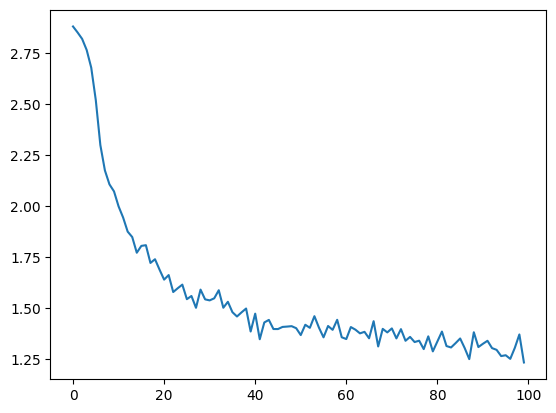

In [79]:
plt.figure()
plt.plot(all_losses)

## Evaluating the Result

<ipython-input-80-ec211a74df8f>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_category, rotation=90)
<ipython-input-80-ec211a74df8f>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_category)


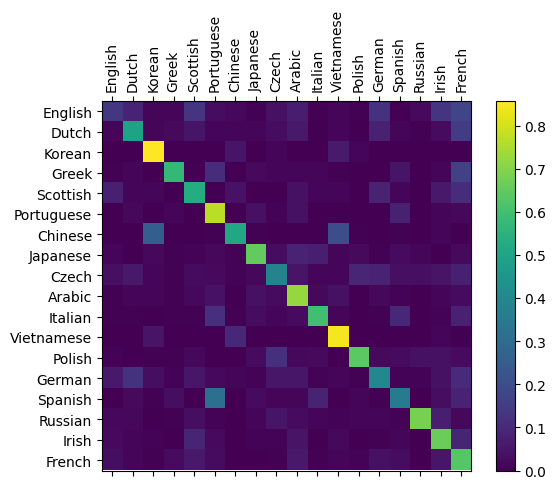

In [80]:
# Keep track of correct guesses in a confusion matrix

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_category, n_category)
n_confusion = 10000



# Just return an output given a word

def evaluate(line_tensor):

  hidden = rnn.initHidden()
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  return output

#convert an line into tensor

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
  # Get random exmaple
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  #get category from output (category, category index)
  guess, guess_i = categoryFromOutput(output)
  # now get true category index
  category_i = all_category.index(category)
  confusion[category_i][guess_i] += 1

# Normalizing data by dividing every row by its sum
for i in range(n_category):
  confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_category, rotation=90)
ax.set_yticklabels([''] + all_category)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()



## Running User input and predict function

In [83]:
def predict(input_word, n_predictions=3):
  print('\n> %s' % input_word)
  #disabling gradient temporarily
  with torch.no_grad():
    output = evaluate(wordsToTensor(input_word))
    topv, topi = output.topk(n_predictions, 1, True)

    predictions = []
    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print('(%.2f) %s' % (value, all_category[category_index]))
      predictions.append([value, all_category[category_index]])



In [84]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.65) Czech
(-1.09) Russian
(-2.27) English

> Jackson
(-0.13) Scottish
(-3.01) English
(-3.52) Czech

> Satoshi
(-1.08) Italian
(-1.31) Japanese
(-1.95) Arabic
